<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_5b_pruning_depth_st_llama3.2-1b-Instruct_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Pruning Llama 3.2.</h2>
    <h3>Example of approach to depth pruning a Llama Model.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)

_______
Models: meta-llama/Llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Pruning
* Structured pruning
* Depth pruning.


Related article:
_______
**disclaimer: The pruning section was created after the first edition of the book was published. They are not included in the book’s original content but are intended to supplement and expand on the topics covered.**

This is the unofficial repository for the book:
        <a href="https://amzn.to/4eanT1g"> <b>Large Language Models:</b> Apply and Implement Strategies for Large Language Models</a> (Apress).
        The book is based in this repository, but the notebooks are being updated, and I am incorporating new examples and chapters.
        If you are looking for the official repository for the book, with the original notebooks, you should visit the
        <a href="https://github.com/Apress/Large-Language-Models-Projects">Apress repository</a>, where you can find all the notebooks in their original format as they appear in the book.
______

# Introduction
This notebook cotinues the work done at: [6_3_pruning_structured_llama3.2-1b_OK.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb) a width pruning was applied to a Llama3.2 model.

In this notebook, we will look at an example of depth pruning, which involves removing entire layers from the model.

The first thing to note is that removing entire layers from a transformer model usually has a significant impact on the model's performance. This is a much more drastic architectural change compared to the simple removal of neurons from the MLP layers, as seen in the previous example.

For this reason, these models are not designed to be used directly after the pruning process. Instead, they will require a subsequent fine-tuning process to recover their capabilities.

#Install libraries & Configure variables.

In [1]:
!pip install -q transformers
!pip install -q torch
!pip install -q datasets
!pip install -q sentencepiece  # Required for LLaMA tokenizer

In [2]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch import nn
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Download model and explore structure

In [4]:
model_name = 'meta-llama/Llama-3.2-1B-Instruct'
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [13]:
def get_output(prompt, model=model, tokenizer=tokenizer):
    # Chat forma for modelInstruct
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Aply chat template
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors='pt'
    ).to(device)

    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        temperature=None,
        top_p=None,
        do_sample=False,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    generated_tokens = outputs[0][len(inputs[0]):]
    generated = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return generated.strip()

## studying the model structure
As demonstrated in the [previous notebook](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb), studying the structure of the model that will undergo pruning is crucial.

In this notebook, we’re going to fine-tune the pruning process for the Llama3.2 model.

In [7]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro


Each layer of the model consists of the attention section and the MLP section. When we remove a layer, the entire layer is eliminated. This is a crucial point because finding a balance in selecting which layers to remove will be challenging.

Later, in future notebooks, you will learn about different techniques for selecting layers, based on their activation and how the model responds to a specific dataset.

In this notebook, you will explore three different layer selection techniques:

- Summing the magnitudes of all the weights in the layers.
- Removing the first layers of the model.
- Removing the last layers of the model.



In [14]:
# Test the original model
prompt = "What is the capital of France?"
generated = get_output(prompt)
print(f"Generated text: {generated}")

Generated text: Paris is both the largest city in France and its capital, as it is where the French government is located.


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [16]:
original_param_count = count_parameters(model)
print(f"Original model parameters: {original_param_count}")

Original model parameters: 1235814400


#Pruning the Model.
##Support pruning functions.

Here are three differeten methods I used to calculate wich layers to mantain.

The function prune_layers calculates the weight magnitude of each layer to remove those that, in principle, should contribute less to the model.

The other two functions focus on removing either the initial layers or the final layers.

The results obtained with 20% pruning using each method have been quite different:

* **prune_layers**: Generated text after pruning: Paris is the capital of & && &ththhth hhh h h shhs h th h f h % h t h

 h m  h   m
  sh  *
 n
* **prune_last_layers**: Paris is the capital of France and arguably one amongstworld renowned cities worldwide. Its uniqueness lies in its uniqueness itselfwhich makes it uniquely unique amongstotherworld renown cities globally.Its uniqueness resides mainly inits unique architecturewhichmakes itunique amongst otherworld
* **prune_first_layer**: Paris is the capital of & && &ththhth hhh h h shhs h th h f h % h t h
 h m  h   m
  sh  *
 n
* **Base model**: Paris is the capital of France and one of the most visited cities in the world. It is a city with a rich history and culture, as well as a vibrant and diverse population. Paris is home to many famous landmarks, including the Eiff

It is clear that the impact on the model has been quite catastrophic in all cases. The only model that managed to generate text—which, while not entirely coherent, at least resembles text—was the one where the final layers were removed.

In a Transformer model like this, layers are organized hierarchically: the initial layers (closer to the input) tend to capture basic language patterns (such as syntactic structure, common word combinations, etc.), while the intermediate and final layers refine these representations, capturing higher-order relationships, global coherence, and subtle semantic nuances.

Removing the initial layers directly undermines the foundation upon which more complex representations are built, leading the model to generate meaningless text sequences. Similarly, removing layers based on weight importance metrics (without considering their position or function) can eliminate layers critical for linguistic cohesion or contextual coherence.

On the other hand, removing the final layers, while resulting in a loss of some refinement and specialization capabilities, preserves the initial and middle layers that have already learned fundamental language rules and basic word dependencies.

However, this is just an empirical and highly simple test. Later, when we evaluate the model's performance using rankings, we will see that it retains a significant portion of its characteristics. Therefore, we are dealing with a model that can deliver very good results after a small fine-tuning process to recover some of the lost capabilities.

In [17]:
#DISCARTED: Eliminate layers with smaller absolute values of all parameters.
def compute_layer_importance(layer):
    """
    Compute the importance score of a layer by considering the sum of
    the absolute values of all its parameters (including attention and MLP).

    Args:
    - layer: A model layer (e.g., LlamaDecoderLayer).

    Returns:
    - layer_importance: A scalar importance score for the entire layer.
    """
    # Initialize a tensor for cumulative sum of absolute parameters
    device = layer.parameters().__next__().device
    layer_importance = torch.tensor(0.0, device=device)

    # Accumulate the absolute values of all parameters in the layer
    for param in layer.parameters():
        layer_importance += torch.sum(torch.abs(param))

    return layer_importance

In [18]:
###
# DISCARTED: Eliminate layers with smaller absolute values of all parameters.
##
def prune_layers(model, prune_percent):
    """
    Removes entire layers from the model based on their importance scores.
    Now considers all parameters in a layer (attention + MLP) for determining importance.

    Args:
    - model: The model from which layers will be pruned.
    - prune_percent: The percentage of layers to remove.

    Returns:
    - model: The pruned model with fewer layers.
    """
    # Calculate the importance of each layer and store (index, importance)
    layer_importances = []
    for idx, layer in enumerate(model.model.layers):
        importance = compute_layer_importance(layer)
        layer_importances.append((idx, importance))

    # Sort layers by importance in ascending order (lowest importance first)
    layer_importances.sort(key=lambda x: x[1])

    # Compute the number of layers to prune
    total_layers = len(layer_importances)
    num_layers_to_prune = int(total_layers * prune_percent)

    # Get the indices of layers to remove
    layers_to_remove = set([x[0] for x in layer_importances[:num_layers_to_prune]])

    # Rebuild the model without the removed layers
    new_layers = [layer for i, layer in enumerate(model.model.layers) if i not in layers_to_remove]
    model.model.layers = nn.ModuleList(new_layers)

    return model

#Generated text after pruning: Paris is the capital of & && &ththhth hhh h h shhs h th h f h % h t h
#
# h m  h   m
#  sh  *
#*
# n

In [19]:
##############
## SELECTED ##
##############
# ELIMINATE LAST LAYERS OF THE MODEL.
def prune_last_layers(model, num_layers_to_remove):
    """
    Removes the last 'num_layers_to_remove' layers from the model.

    Args:
    - model: The model from which layers will be pruned.
    - num_layers_to_remove: Number of layers to remove from the top of the stack.

    Returns:
    - model: The pruned model with fewer layers.
    """
    total_layers = len(model.model.layers)

    # Ensure we are not removing more layers than exist
    if num_layers_to_remove >= total_layers:
        raise ValueError("Number of layers to remove is greater or equal to total layers.")

    # Slice the layers to remove the last ones
    new_layers = model.model.layers[:total_layers - num_layers_to_remove]
    model.model.layers = nn.ModuleList(new_layers)

    # Update the model configuration
    model.config.num_hidden_layers = len(model.model.layers)

    return model
#response:  Paris is the capital of France and arguably one amongstworld renowned cities worldwide. Its uniqueness lies in its uniqueness itselfwhich makes it uniquely unique amongstotherworld renown cities globally.Its uniqueness resides mainly inits unique architecturewhichmakes itunique amongst otherworld

In [20]:
###
# DISCARTED: Eliminate first model layers.
##
def prune_first_layers(model, num_layers_to_remove):
    """
    Removes the first 'num_layers_to_remove' layers from the model.

    Args:
    - model: The model from which layers will be pruned.
    - num_layers_to_remove: Number of layers to remove from the start.

    Returns:
    - model: The pruned model with fewer layers.
    """
    # Get the total number of layers in the model.
    total_layers = len(model.model.layers)

    # Ensure we are not removing more layers than exist
    if num_layers_to_remove >= total_layers:
        raise ValueError("Number of layers to remove is greater or equal to total layers.")

    # Keep all layers after the first 'num_layers_to_remove'
    new_layers = model.model.layers[num_layers_to_remove:]
    model.model.layers = nn.ModuleList(new_layers)

    # Update the model configuration after pruning layers
    model.config.num_hidden_layers = len(model.model.layers)

    return model

#response: Paris is the capital of & && &ththhth hhh h h shhs h th h f h % h t h
#
# h m  h   m
#  sh  *
#*
# n

# Prune Loop
The update_model function iterates through the blocks within the model's Transformer structure. This structure consists of multiple `LlamaDecoderLayer` blocks, and each of these blocks contains a pair of `LlamaSdpaAttention` and `LlamaMLP` components.
```
(layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
  )    


In [21]:
def update_model(model, prune_percent):
    """
    Modifies the model by removing entire layers from the end of the stack,
    instead of basing it on importance scores. This is a heuristic approach
    that tries pruning the top layers to see if it yields better results.

    Args:
    - model: Model to prune.
    - prune_percent: Percentage of layers to prune from the top.

    Returns:
    - model: New pruned model with fewer layers.
    """
    ### uncomment this if you want to use weight layer selection.
    #model = prune_layers(model, prune_percent)

    total_layers = len(model.model.layers)
    num_layers_to_remove = int(total_layers * prune_percent)

    model = prune_last_layers(model, num_layers_to_remove)
    #model = prune_first_layers(model, num_layers_to_remove)

    # Update the model configuration to reflect the new number of layers
    model.config.num_hidden_layers = len(model.model.layers)
    return model


## Obtain & test the pruned model.

In [22]:
prune_percent = 0.2  # Prune 20% of neurons
model = update_model(model, prune_percent)

In [23]:
# Recalculate the number of parameters
pruned_param_count = count_parameters(model)
reduction_in_params = original_param_count - pruned_param_count
percentage_savings = (reduction_in_params / original_param_count) * 100

print(f"Pruned model parameters: {pruned_param_count}")
print(f"Reduction in parameters: {reduction_in_params}")
print(f"Percentage of weight savings: {percentage_savings:.2f}%")


Pruned model parameters: 1053349888
Reduction in parameters: 182464512
Percentage of weight savings: 14.76%


In [24]:
# Test the pruned model
generated = get_output(prompt, model, tokenizer)
print(f"Generated text after pruning: {generated}")

Generated text after pruning: Paris is indeed considered as capital city of france however technically speaking capitals capitals are usually referred to as Capitals capitals themselves rather than just Capitals themselves because typically there are multiple capitals depending upon how many countries are involved amongst others such as Vatican City which is seperate from mainland europe however amongst european nationssuch as france france itself serves as both capitals whilst others like france also recogniseother countries like France as their own respective capitals additionally sometimes termed as administrative capitals or administrative centers depending on context however generally speaking amongst internationally recognised sovereign nations like countries internationally recognized as nations themselvessuch


The result is realy different from what the original model produced, and is far to be a fairly accurate response, but at least is understable text.

In contrast to the model created in notebook: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb) where the pruned Llama model lost almost all its utility, the model in this notebook retains a good portion of its knowledge.

Looking at the model’s new structure, we can see that now the model have only 13 layers instead of the 16 original. So we removed 3 entire layers.

In [25]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-12): 13 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

#Upload the model to HuggingFace.

In [26]:
new_model_name = 'depth20-llama-3.2-1b-Instruct'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./depth20-llama-3.2-1b-Instruct


In [27]:
# Push the model to your Hugging Face repository

model.push_to_hub(new_model_name, private=True)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...nstruct/model.safetensors:   0%|          | 7.48MB / 2.11GB            

CommitInfo(commit_url='https://huggingface.co/oopere/depth20-llama-3.2-1b-Instruct/commit/43190679cb3f8021b3b9210f1ca82501f27bcf27', commit_message='Upload LlamaForCausalLM', commit_description='', oid='43190679cb3f8021b3b9210f1ca82501f27bcf27', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oopere/depth20-llama-3.2-1b-Instruct', endpoint='https://huggingface.co', repo_type='model', repo_id='oopere/depth20-llama-3.2-1b-Instruct'), pr_revision=None, pr_num=None)

In [28]:
tokenizer.push_to_hub(new_model_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...b-Instruct/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

CommitInfo(commit_url='https://huggingface.co/oopere/depth20-llama-3.2-1b-Instruct/commit/d26ffc0a788b69f0cc7e7c4dc8a42573141d572a', commit_message='Upload tokenizer', commit_description='', oid='d26ffc0a788b69f0cc7e7c4dc8a42573141d572a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oopere/depth20-llama-3.2-1b-Instruct', endpoint='https://huggingface.co', repo_type='model', repo_id='oopere/depth20-llama-3.2-1b-Instruct'), pr_revision=None, pr_num=None)

#Evaluating models

In this section, we'll take a look at some standard evaluations in the world of Large Language Models using the lm-evaluation library from EleutherAI.

Specifically, we'll use LAMBADA, ARC_EASY and BoolQ. Since the pruning performed could be considered structural—that is, it affects the model's overall structure without a specific target—I’ve chosen rather different evaluation tasks.

I want to remind you that the goal of this notebook is to demonstrate the pruning process, so I won’t be doing a comprehensive study of how it impacts performance; that will be saved for a future article. Additionally, these models are designed to be fine-tuned before being used.

However, I believe that seeing how pruning impacts model performance can help illustrate the pruning process itself.

The model selected for the comparision is the one with a 20% pruning using the last layers selection.

In [29]:
!pip install -q lm-eval
from lm_eval import evaluator, tasks, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 11.1 MB/s eta 0:00:00


In [30]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [31]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq', 'arc_easy']

In [32]:
metrics_pruned = evaluate_hf_model("oopere/depth20-llama-3.2-1b-Instruct", tasks=tasks)

        applied. Recommend setting `apply_chat_template` (optionally `fewshot_as_multiturn`).


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

default/test/default.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00002.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

plain_text/train-00001-of-00002.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

boolq/train-00000-of-00001.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

boolq/validation-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

boolq/test-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

ARC-Easy/test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

ARC-Easy/validation-00000-of-00001.parqu(…):   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 26347/26347 [09:14<00:00, 47.55it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 100.72it/s]

bootstrapping for stddev: perplexity



100%|██████████| 1/1 [00:00<00:00, 92.36it/s]


In [33]:
metrics_pruned

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.48737373737373735,
  'acc_stderr,none': 0.010256511718330434,
  'acc_norm,none': 0.47474747474747475,
  'acc_norm_stderr,none': 0.010246690042583878},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6498470948012233,
  'acc_stderr,none': 0.008343091327001046},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 70919.50782999441,
  'perplexity_stderr,none': 7092.359624426455,
  'acc,none': 0.09819522608189404,
  'acc_stderr,none': 0.004145849428034497},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 352292.3966355288,
  'perplexity_stderr,none': 38153.295849679285,
  'acc,none': 0.08461090626819329,
  'acc_stderr,none': 0.0038772884649187285}}

In [34]:
metrics_base= evaluate_hf_model("meta-llama/Llama-3.2-1B-Instruct", tasks=tasks)

        applied. Recommend setting `apply_chat_template` (optionally `fewshot_as_multiturn`).
Running loglikelihood requests: 100%|██████████| 26347/26347 [44:07<00:00,  9.95it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 94.15it/s]

bootstrapping for stddev: perplexity



100%|██████████| 1/1 [00:00<00:00, 101.44it/s]


In [35]:
metrics_base

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6851851851851852,
  'acc_stderr,none': 0.009530150430975505,
  'acc_norm,none': 0.6313131313131313,
  'acc_norm_stderr,none': 0.009899640855681058},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6951070336391437,
  'acc_stderr,none': 0.008051783411024705},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 6.578904811488175,
  'perplexity_stderr,none': 0.3159444429362019,
  'acc,none': 0.5977100718028333,
  'acc_stderr,none': 0.006831670941073277},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 13.07208941627685,
  'perplexity_stderr,none': 0.665570718637886,
  'acc,none': 0.47952648942363674,
  'acc_stderr,none': 0.006960135424338517}}

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(metrics_base, metrics_pruned):
    """
    Genera un gráfico de barras comparativo entre el modelo base y el podado.

    Args:
        metrics_base (dict): Diccionario con los resultados del modelo base.
        metrics_pruned (dict): Diccionario con los resultados del modelo podado.
    """

    # 1. Definir las tareas y las etiquetas para el eje X
    #    (basado en el orden y nombres de tu imagen)
    tasks_to_plot = ['boolq', 'lambada_openai', 'lambada_standard', 'arc_easy']
    display_labels = ['BoolQ', 'Lambada OpenAI', 'Lambada Standard', 'arc_easy']

    # 2. Extraer las puntuaciones de precisión ('acc,none')
    try:
        base_scores = [metrics_base[task]['acc,none'] for task in tasks_to_plot]
        pruned_scores = [metrics_pruned[task]['acc,none'] for task in tasks_to_plot]
    except KeyError as e:
        print(f"Error: No se encontró la clave {e}.")
        print(f"Asegúrate de que todas las tareas ({tasks_to_plot})")
        print("y la métrica 'acc,none' existan en ambos diccionarios.")
        return

    # 3. Configurar las posiciones de las barras
    n_groups = len(tasks_to_plot)
    index = np.arange(n_groups)
    bar_width = 0.35

    # 4. Crear el gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colores que coinciden con la imagen adjunta (Colores clásicos de Google Charts)
    color_base = '#3366CC'
    color_pruned = '#DC3912'

    # Dibujar las barras
    ax.bar(index - bar_width / 2,
           base_scores,
           bar_width,
           label='Base Model',
           color=color_base)

    ax.bar(index + bar_width / 2,
           pruned_scores,
           bar_width,
           label='Pruned Model',
           color=color_pruned)

    # 5. Añadir etiquetas, título y leyenda
    ax.set_title('Base Model vs Pruned Model', fontsize=18, pad=20)

    # Configuramos el eje Y para que coincida con la imagen (de 0.0 a 0.8+, con espacio)
    ax.set_ylim([0, 0.9])
    ax.set_yticks(np.arange(0, 0.9, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Añadir las etiquetas del eje X
    ax.set_xticks(index)
    ax.set_xticklabels(display_labels)

    # Añadir la cuadrícula horizontal (detrás de las barras)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
    ax.set_axisbelow(True)

    # Añadir la leyenda (como en la imagen)
    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=2, frameon=False)

    # 6. Mostrar el gráfico
    plt.tight_layout()
    plt.show()

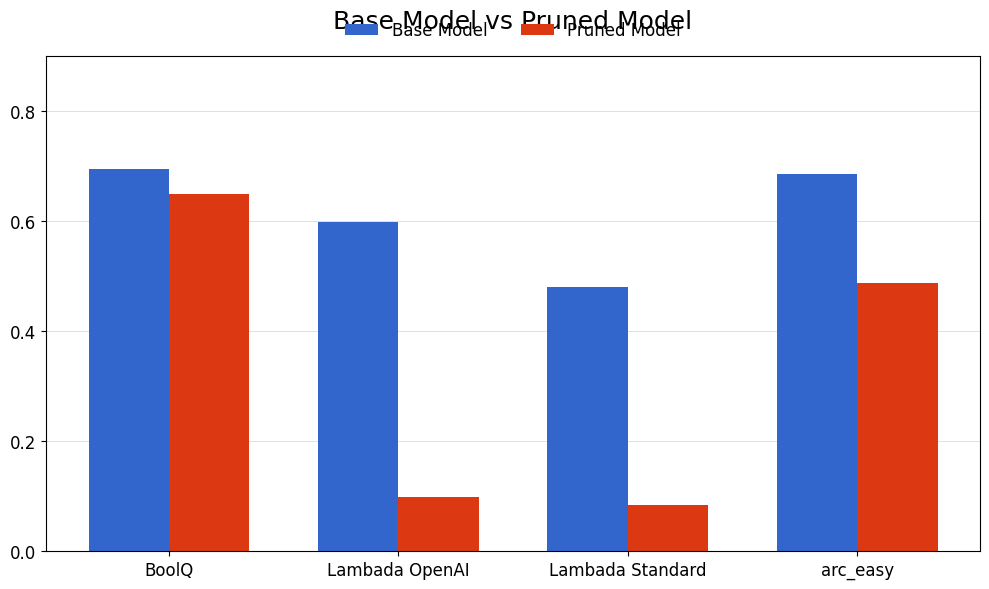

In [37]:
plot_model_comparison(metrics_base, metrics_pruned)

**BoolQ:** The performance drop is minimal (from 0.64 to 0.63). BoolQ is a dataset of boolean (true/false) questions based on reading comprehension. The fact that the model nearly maintains its performance suggests that the information required to answer these questions is less sensitive to layer removal or that this type of task primarily benefits from more basic language information, which remains intact after pruning.

**Lambada (OpenAI and Standard):** Here, the performance drop is much more pronounced, alsmost dramatic, a drastic reduction. Lambada focuses on predicting the last word in a text, requiring deep contextual understanding and long-term coherence. This result aligns with the earlier test in the notebook, where the model was asked to complete a prompt, and the generated language was not entirely accurate. This difficulty in producing coherent text within a given context negatively impacted its performance in the evaluated task.

**ARC Easy:** This benchmark also shows a significant decline (from 0.65 to 0.44). ARC Easy is a reasoning benchmark focused on general knowledge and common sense. The removal of layers likely impacted the model's ability to relate information and maintain reasoning chains, resulting in a reduced capacity to select the correct answer.

#Conclusion.

In this notebook, we explored how depth pruning works on Llama-3.2 Instruct models.

After pruning, the model maintains the ability to work as an instruct model, meaning maintaining a dialog with the user, but experiences significant degradation in tasks that require greater contextual and semantic reasoning (Lambada, ARC Easy), while its performance on BoolQ, a comparatively simpler task, remains almost unchanged. This suggests that pruning disproportionately affects the parts of the model that facilitate complex understanding and long-term coherence. BoolQ, being simpler or less dependent on these traits, remains relatively stable, whereas tasks that evaluate context and global coherence are severely impacted.

As indicated in the paper: What Matters in Transformers? What Matters in Transformers? Not All Attention is Needed. https://arxiv.org/abs/2406.15786 the best result is achieved by removing the deepest layers of the model.


## Future Work.

So far, we have explored two forms of structured pruning:

- Width pruning: In this approach, neurons from the MLP layers of two model families, DistilGPT and Llama3, were removed. The process of removing neurons from models with GLU architecture works across all families with this structure, such as QWEN, Gemma, or Microsoft Phi.
- Depth pruning: Entire blocks were removed from a Llama3 model. This technique can be adapted to all model families.

The common point is that we have used very similar methods to decide which elements to remove from the models, based on the absolute weight of the parameters. The next step will involve making these decisions based on metrics generated while the model is running. This will allow us to create models tailored to specific datasets.

##Authors Note.
In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: <a href="https://amzn.to/4eanT1g"><b>Large Language Models:</b> Apply and Implement Strategies for Large Language Models</a> (Apress).

You can find it on both <a href="https://amzn.to/4eanT1g">Amazon</a> and <a href="https://link.springer.com/book/10.1007/979-8-8688-0515-8">Springer</a>, where they often have good deals on the purchase price.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.

## References.
- He, S., Sun, G., Shen, Z., & Li, A. (2024). What matters in transformers? not all attention is needed. arXiv preprint arXiv:2406.15786.

- Kim, B. K., Kim, G., Kim, T. H., Castells, T., Choi, S., Shin, J., & Song, H. K. (2024). Shortened llama: A simple depth pruning for large language models. arXiv preprint arXiv:2402.02834, 11.

- Martra, P. (2024). EXPLORING GLU EXPANSION RATIOS: STRUCTURED PRUNING IN LLAMA-3.2 MODELS. https://doi.org/https://doi.org/10.31219/osf.io/qgxea